# The Impact of Remote Work on São Paulo's Real Estate Market: A Spatial Regression Analysis of Price Dynamics
This notebook has the objective of analyzing the impact of remote work on São Paulo's real estate market. The analysis focuses on the relationship between the teleworkability index and property prices in different districts of São Paulo. The study uses spatial regression models to account for spatial dependencies and commuting patterns between districts. The analysis is conducted for the years 2018 to 2021 to understand how the relationship between teleworkability and property prices has evolved over time.

### 1. Importing and Loading Required Libraries

#### 1.1. Installing and Loading Required Packages
This section installs and loads essential R packages for data analysis and visualization. The `stargazer` package is used for creating well-formatted tables. The `spatialreg` package is utilized for spatial regression analysis, and the `sf` package is used for spatial data manipulation. The `flextable` package is used for creating tables. The `spdep` package offers spatial dependence methods. The `tmap` package is used for thematic mapping, and `corrr` is for exploring correlations. The `ggplot2` package is used for visualization, and `ggcorrplot` creates correlation plots. The `car` package offers regression diagnostics, and `HH` provides additional statistical methods. Both `gridExtra` and `cowplot` help arrange multiple plots.



In [ ]:
install.packages(c("stargazer", "spatialreg", "sf", "flextable", "spdep", "corrr", "ggplot2", "ggcorrplot", "car", "HH", "gridExtra", "cowplot", "dplyr"))
library(stargazer) #for creating tables of regression results
library(spatialreg) #for spatial regression analysis
library(sf) #for spatial data manipulation
library(flextable) #for creating tables
library(spdep) #for spatial dependence methods
library(corrr) #for exploring correlations
library(ggplot2) #for visualization
library(ggcorrplot) #for correlation plots
library(car) #for regression diagnostics
library(HH) #for additional statistical methods
library(gridExtra) #for arranging multiple plots
library(cowplot) #for arranging multiple plots
library(dplyr) #for filter the data by year and remove outliers

---
### 2. Data Preparation and Transformation

#### 2.1. Reading the Main Data Frame
Reading the data from the CSV file and displaying the first few rows to understand the structure of the data.

In [2]:
data_sell <- read.csv("/Users/karimmbk/Documents/halef-thesis/web-scraper/resources/clean-data/sell/sell_2018_2021.csv", dec = ".", header = TRUE, sep = ",")

#### 2.2. Convert categorical variables to factors (dummy variables)
Converting categorical variables to factors to use them in the regression model. The variables `gym`, `field_quadra`, `elevator`, `furnished`, and `swimming_pool` are dummy variables and thus need to be converted to factors.

In [3]:
# Factorizing the categorical variables
data_sell$gym <- as.factor(data_sell$gym)
data_sell$field_quadra <- as.factor(data_sell$field_quadra)
data_sell$elevator <- as.factor(data_sell$elevator)
data_sell$furnished <- as.factor(data_sell$furnished)
data_sell$swimming_pool <- as.factor(data_sell$swimming_pool)

#### 2.3. Convert date to date format
Converting the date column to a date format to filter the data by year. The date column is in the format `dd/mm/yyyy`.

In [4]:
data_sell$date <- as.Date(data_sell$date, format = "%d/%m/%Y")

#### 2.4. Filter the data by year
Filtering the data by year allows us to run the regression model for each year studied. We can understand the relationship between the variables over time by running the regression for each year. The study will focus on understanding how `price_m2` behaves with the variation of the `teleworkable` index over time.

In [8]:
# Filtering the data by year to run the regression model for each year studied
data_sell_2018 <- filter(data_sell, year == 2018)
data_sell_2019 <- filter(data_sell, year == 2019)
data_sell_2020 <- filter(data_sell, year == 2020)
data_sell_2021 <- filter(data_sell, year == 2021)

# Set the final data that will be used in the model
data_sell_final <- data_sell_2018
print(nrow(data_sell))
print(nrow(data_sell_final))

[1] 23902
[1] 15573


#### 2.5. Data Cleaning
Defining a function to remove outliers from a DataFrame based on the interquartile range (IQR) method, specifically targeting the `price_m2` column. It calculates the IQR and uses it to filter out values that fall outside 1.5 times the IQR from the first and third quartiles. The filtered DataFrame is then returned, and the number of removed lines and final rows are printed.

In [9]:
# Fuction to remove outliers
remove_outliers <- function(df, column_name) {

  # Defining the DataFrame to be cleaned
  df_filtered <- df

  # Removing outliers from the DataFrame using the IQR method
  q1_preco_mes <- quantile(df$price_m2, 0.25, na.rm = TRUE)
  q3_preco_mes <- quantile(df$price_m2, 0.75, na.rm = TRUE)
  iqr_preco_mes <- q3_preco_mes - q1_preco_mes
  lower_bound_preco_mes <- q1_preco_mes - 1.5 * iqr_preco_mes
  upper_bound_preco_mes <- q3_preco_mes + 1.5 * iqr_preco_mes

  # Using the price per square meter as the reference for the filter
  df_filtered <- df_filtered[df_filtered$price_m2 >= lower_bound_preco_mes & df_filtered$price_m2 <= upper_bound_preco_mes,]

  return(df_filtered)
}

df_filtered <- remove_outliers(data_sell_final, "price_m2")
print(paste("Number of removed lines:", nrow(data_sell_final) - nrow(df_filtered)))
print(paste("Number of final rows:", nrow(df_filtered)))

[1] "Number of removed lines: 558"
[1] "Number of final rows: 15015"


---
### 3. Create the spatial weights matrix
The calculation of the `teleworkability` index assumes that individuals work and reside in the same district. To address this issue, the main model will be re-estimated with a spatial econometric specification. This specification will include a spatial lag of the `teleworkability` index vector, utilizing a spatial weight matrix `commute_matrix` constructed from inter-district commuting flows. This approach will help control for the differing locations of employment and residences.

#### 3.1. Importing the Commute Matrix and Normalizing the Data
This code imports a commute matrix from a CSV file and normalizes it to calculate the proportion of commuters between locations. The normalization transforms each entry to represent the proportion of commuters from one location relative to the total number of commuters from that location. This provides a clearer view of commuting patterns and relative flows between areas.

In [10]:
# Import the commute matrix
commute_matrix <- read.csv("/Users/karimmbk/Documents/halef-thesis/occupation/commute_matrix.csv", dec = ".", header = TRUE, sep = ",") %>% as.matrix()

# Normalize the data by dividing each row by the row sum to get the proportion of commuters
commute_matrix_normalized <- sweep(commute_matrix, 1, rowSums(commute_matrix), "/")

#### 3.2. Import the Teleworkability Index Vector for Each Year
This code imports the teleworkability index data for each year from 2018 to 2021 from CSV files. It then converts the `weighted_avg_teleworkable_score` column of each imported matrix into a numeric vector. These vectors represent the teleworkability index for different districts in São Paulo for each respective year.

In [13]:
# Import the teleworkability index vector for each year and make it a numeric vector
teleworkability_index_2018 <- read.csv("/Users/karimmbk/Documents/halef-thesis/occupation/teleworkability_district_SP_2018.csv", dec = ".", header = TRUE, sep = ",") %>%  as.matrix()
teleworkability_vector_2018 <- as.numeric(teleworkability_index_2018 [,6])
teleworkability_index_2019 <- read.csv("/Users/karimmbk/Documents/halef-thesis/occupation/teleworkability_district_SP_2019.csv", dec = ".", header = TRUE, sep = ",") %>% as.matrix()
teleworkability_vector_2019 <- as.numeric(teleworkability_index_2019 [,6])
teleworkability_index_2020 <- read.csv("/Users/karimmbk/Documents/halef-thesis/occupation/teleworkability_district_SP_2020.csv", dec = ".", header = TRUE, sep = ",") %>% as.matrix()
teleworkability_vector_2020 <- as.numeric(teleworkability_index_2020 [,6])
teleworkability_index_2021 <- read.csv("/Users/karimmbk/Documents/halef-thesis/occupation/teleworkability_district_SP_2021.csv", dec = ".", header = TRUE, sep = ",") %>% as.matrix()
teleworkability_vector_2021 <- as.numeric(teleworkability_index_2021 [,6])

#### 3.3. Including the spacial lag of the teleworkability index in the model
This code calculates the `spatial lag of the teleworkability index` for each year from 2018 to 2021. It multiplies the `normalized commute matrix` by the `teleworkability vector` for each year, resulting in a new vector that represents the `spatially lagged teleworkability index`, accounting for the influence of commuting patterns between districts.

In [14]:
spatial_lag_teleworkability_2018 <- commute_matrix_normalized %*% teleworkability_vector_2018
spatial_lag_teleworkability_2019 <- commute_matrix_normalized %*% teleworkability_vector_2019
spatial_lag_teleworkability_2020 <- commute_matrix_normalized %*% teleworkability_vector_2020
spatial_lag_teleworkability_2021 <- commute_matrix_normalized %*% teleworkability_vector_2021

This code combines the `teleworkability index's first and third` columns (ID and year) with the `spatially lagged` teleworkability index for each year from 2018 to 2021. It creates a data frame for each year by first extracting the relevant columns (ID and year) from the original teleworkability index data, then binding these columns with the spatially lagged teleworkability index

In [15]:
teleworkability_index_2018_first_collunm <- as.data.frame(teleworkability_index_2018 [,c(1,3)])
teleworkability_index_2018_matrix <- cbind(teleworkability_index_2018_first_collunm, spatial_lag_teleworkability_2018)
colnames(teleworkability_index_2018_matrix) <- c("ID", "year", "teleworkability_adj")
teleworkability_index_2019_first_collunm <- as.data.frame(teleworkability_index_2019 [,c(1,3)])
teleworkability_index_2019_matrix <- cbind(teleworkability_index_2019_first_collunm, spatial_lag_teleworkability_2019)
colnames(teleworkability_index_2019_matrix) <- c("ID", "year", "teleworkability_adj")
teleworkability_index_2020_first_collunm <- as.data.frame(teleworkability_index_2020 [,c(1,3)])
teleworkability_index_2020_matrix <- cbind(teleworkability_index_2020_first_collunm, spatial_lag_teleworkability_2020)
colnames(teleworkability_index_2020_matrix) <- c("ID", "year", "teleworkability_adj")
teleworkability_index_2021_first_collunm <- as.data.frame(teleworkability_index_2021 [,c(1,3)])
teleworkability_index_2021_matrix <- cbind(teleworkability_index_2021_first_collunm, spatial_lag_teleworkability_2021)
colnames(teleworkability_index_2021_matrix) <- c("ID", "year", "teleworkability_adj")

This code combines the data frames containing the adjusted teleworkability index for each year from 2018 to 2021 into a single data frame. The `rbind` function is used to bind the rows of the yearly matrices together, and the resulting matrix is then converted into a data frame with `as.data.frame`. This consolidated data frame, `teleworkability_adj_matrix`, allows for comprehensive analysis across all years.

In [16]:
teleworkability_adj_matrix <- rbind(teleworkability_index_2018_matrix, teleworkability_index_2019_matrix, teleworkability_index_2020_matrix, teleworkability_index_2021_matrix)
teleworkability_adj_matrix <- as.data.frame(teleworkability_adj_matrix)

This code prepares and merges two data frames by matching on the "ID" and "year" columns. First, it converts the "ID" and "year" columns in both `df_filtered` and `teleworkability_adj_matrix` to integer type. Then, it performs a left join to merge `teleworkability_adj_matrix` into `df_filtered` based on the "ID" and "year" columns, resulting in a combined data frame that includes the teleworkability adjusted index.

In [17]:
df_filtered$ID <- as.integer(df_filtered$ID)
teleworkability_adj_matrix$ID <- as.integer(teleworkability_adj_matrix$ID)
df_filtered$year <- as.integer(df_filtered$year)
teleworkability_adj_matrix$year <- as.integer(teleworkability_adj_matrix$year)
df_filtered <- left_join(df_filtered, teleworkability_adj_matrix, by = c("ID", "year"))

---
### 4. Exploratory Data Analysis (EDA)


In [46]:
print(colnames(df_filtered))

 [1] "rank"                "link"                "quarter"            
 [4] "year"                "date"                "title"              
 [7] "address"             "area_m2"             "bedrooms"           
[10] "suite"               "bathrooms"           "garage"             
[13] "price_real_month"    "price_m2"            "condo_real"         
[16] "zone"                "district"            "characteristics"    
[19] "createdat"           "address_google"      "latitude"           
[22] "longitude"           "metro_dist_km"       "metro_close"        
[25] "metro_line"          "gym"                 "field_quadra"       
[28] "elevator"            "furnished"           "swimming_pool"      
[31] "ID"                  "CD_GEOCODD"          "NM_DISTRIT"         
[34] "delta_cbd_farialima" "delta_cbd_paulista"  "inequality_meter"   
[37] "inequality_rank"     "teleworkable"        "sport_space"        
[40] "mortality_children"  "mortality_mom"       "teen_pregnant"      
[43] "

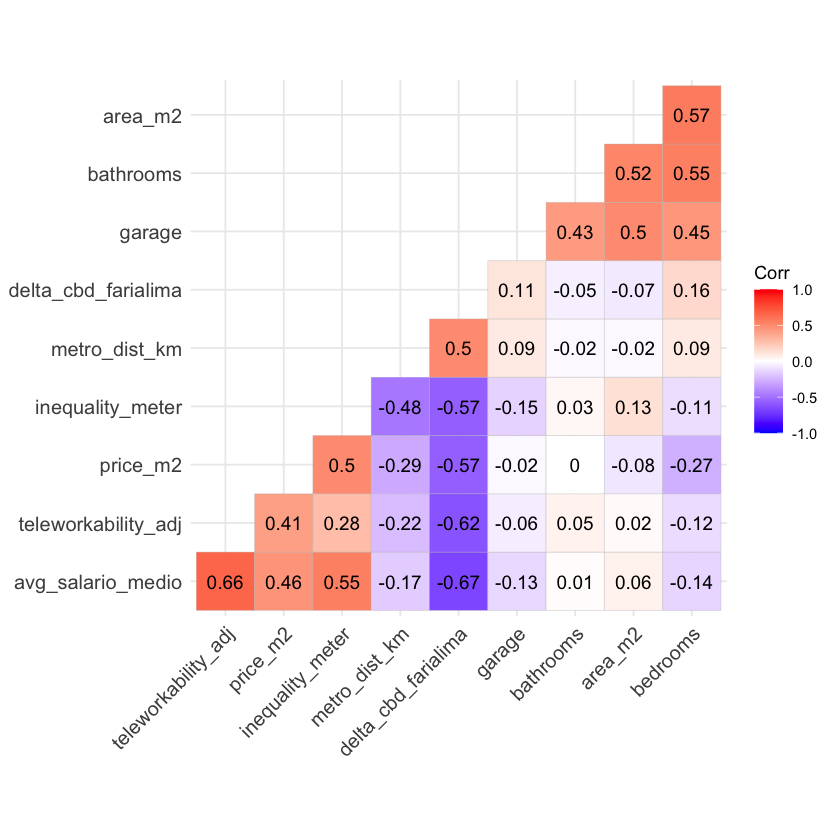

In [45]:
library(corrr)
# Select and ensure all columns are numeric
corr_data <- df_filtered[, (names(df_filtered) %in% c("price_m2", "area_m2", "bedrooms", "bathrooms","teleworkability_adj", "metro_dist_km", "delta_cbd_farialima", "inequality_meter", "garage", "avg_salario_medio" ))]

# Convert all columns to numeric
corr_data <- data.frame(lapply(corr_data, function(x) as.numeric(as.character(x))))

# Compute correlation at 2 decimal places
corr_matrix <- round(cor(corr_data, use = "complete.obs"), 2)
ggcorrplot(corr_matrix, hc.order = TRUE, type = "lower", lab = TRUE)

#### 3.1. Defining the Model parameters
This subsection defines the formula for the regression model, specifying `price_m2` as the dependent variable and various property features as independent variables.

In [50]:
price_m2_log <- log(df_filtered$price_m2)
params <- (price_m2_log ~ teleworkability_adj + 
  area_m2 +
  bedrooms +
  bathrooms + 
  metro_dist_km +
  delta_cbd_farialima +
  inequality_meter +
  garage +
  avg_salario_medio +
  gym +
  field_quadra +
  elevator +
  swimming_pool)

#data_sell_final_2018 <- filter(data_sell_final, year(date) == 2018)
reg <- lm(params, data = df_filtered)

#### 3.2 Checking the results for the linear regression model
Checking the results for the linear regression model to understand the relationship between the variables.

In [51]:
summary(reg)


Call:
lm(formula = params, data = df_filtered)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.3882 -0.1387 -0.0074  0.1535  0.3072 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)          7.415e+00  6.057e-01  12.243 8.11e-14 ***
teleworkability_adj  2.609e+00  1.262e+00   2.067   0.0467 *  
area_m2             -3.267e-03  2.297e-03  -1.423   0.1643    
bedrooms            -9.139e-02  1.029e-01  -0.888   0.3808    
bathrooms            5.560e-02  8.283e-02   0.671   0.5068    
metro_dist_km       -1.325e-02  1.517e-02  -0.873   0.3890    
delta_cbd_farialima -1.750e-02  1.165e-02  -1.503   0.1424    
inequality_meter     9.982e-03  4.035e-03   2.474   0.0187 *  
garage               1.824e-01  8.116e-02   2.248   0.0314 *  
avg_salario_medio   -1.501e-05  3.767e-05  -0.398   0.6928    
gym1                 6.422e-02  1.093e-01   0.588   0.5607    
field_quadra1       -2.001e-02  9.305e-02  -0.215   0.8311    
elevator1            5.0

#### 3.1.1 Running the diagnostic tests
Running the diagnostic tests to check the normality, heteroskedasticity, and autocorrelation of the residuals

In [52]:
# Load necessary packages
if (!requireNamespace("nortest", quietly = TRUE)) {
  install.packages("nortest")
}
if (!requireNamespace("lmtest", quietly = TRUE)) {
  install.packages("lmtest")
}
library(nortest)
library(lmtest)

# Perform Shapiro-Wilk test or Anderson-Darling test based on sample size
residuals_best_model <- resid(reg)
sample_size <- length(residuals_best_model)

if (sample_size >= 3 && sample_size <= 5000) {
  shapiro_test <- shapiro.test(residuals_best_model)
  print(shapiro_test)
  if (shapiro_test$p.value > 0.05) {
    print("Pass: Residuals are normally distributed (fail to reject H0).")
  } else {
    print("Fail: Residuals are not normally distributed (reject H0).")
  }
} else {
  ad_test <- ad.test(residuals_best_model)
  print(ad_test)
  if (ad_test$p.value > 0.05) {
    print("Pass: Residuals are normally distributed (fail to reject H0).")
  } else {
    print("Fail: Residuals are not normally distributed (reject H0).")
  }
}

# Perform Breusch-Pagan test for heteroskedasticity
bp_test <- bptest(reg)
print(bp_test)
if (bp_test$p.value < 0.05) {
  print("Fail: Heteroskedasticity detected (reject H0).")
} else {
  print("Pass: No heteroskedasticity detected (fail to reject H0).")
}

# Perform Durbin-Watson test for autocorrelation
dw_test <- dwtest(reg)
print(dw_test)
dw_stat <- dw_test$statistic
if (dw_stat < 1.5) {
  print("Fail: Positive autocorrelation detected.")
} else if (dw_stat > 2.5) {
  print("Fail: Negative autocorrelation detected.")
} else {
  print("Pass: No autocorrelation detected.")
}

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric





	Shapiro-Wilk normality test

data:  residuals_best_model
W = 0.97319, p-value = 0.3486

[1] "Pass: Residuals are normally distributed (fail to reject H0)."

	studentized Breusch-Pagan test

data:  reg
BP = 11.687, df = 13, p-value = 0.5535

[1] "Pass: No heteroskedasticity detected (fail to reject H0)."

	Durbin-Watson test

data:  reg
DW = 1.3918, p-value = 0.007381
alternative hypothesis: true autocorrelation is greater than 0

[1] "Fail: Positive autocorrelation detected."


#### 3.1.2. Spatial Regression Model

In [ ]:
update.packages(ask = FALSE, checkBuilt = TRUE)
install.packages("spdep")
install.packages("sf")
install.packages("KernSmooth")
library(spdep)

coords <- as.matrix(df_filtered[, c("longitude", "latitude")])
nb <- knn2nb(knearneigh(coords, k = 3))
listw <- nb2listw(nb, style = "W")

also installing the dependencies ‘Deriv’, ‘microbenchmark’, ‘doBy’


